<a href="https://colab.research.google.com/github/alicetrobinson/W266-project/blob/main/Moral_stories_Transformer_BL_Action_(ATR)_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing LoRA

**Description:** This assignment is on Moral stores: https://huggingface.co/datasets/demelin/moral_stories/viewer/cls-action+context+consequence-norm_distance?row=1

Previous work - Hyperparameter tuning https://colab.research.google.com/drive/1r0-ctP_38zl7WvJ_bPOyjjcVcymg0AZm#scrollTo=so-yur1S9mS4

## 0. Setup

### 0.1. Libraries and Helper Functions

This notebook requires the Hugging Face datasets and other prerequisites that you must download.  

In [ ]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -q datasets
!pip install -q evaluate
!pip install -q transformers[torch]
!pip install -q peft
!pip install -q accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Now we are ready to do the imports.

In [ ]:
#@title Imports

import numpy as np

import transformers
import evaluate

from datasets import load_dataset
from torchinfo import summary

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType

### 0.2 Data Acquisition


We will use the Moral Stores dataset delivered as part of the TensorFlow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [ ]:
from datasets import load_dataset

# Load the dataset
moral_dataset = load_dataset("demelin/moral_stories", "cls-action+context+consequence-norm_distance")

# Select only the first 4000 for training and first 1000 for testing
moral_train_dataset = moral_dataset['train'].shuffle().select(range(20000))
moral_dev_dataset = moral_dataset['test'].shuffle().select(range(2000))


README.md:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

moral_stories.py:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.70M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/374k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/374k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# the size of moral_dataset

len(moral_dataset['train']), len(moral_dataset['test'])


(20000, 2000)

It is always highly recommended to look at the data. What do the records look like? Are they clean or do they contain a lot of cruft (potential noise)?

In [ ]:
moral_train_dataset

Dataset({
    features: ['ID', 'norm', 'situation', 'intention', 'moral_action', 'moral_consequence', 'immoral_action', 'immoral_consequence', 'label'],
    num_rows: 20000
})

In [ ]:
for i in range(4):
  print(moral_train_dataset['situation'][i])
  print(moral_train_dataset['moral_action'][i])
  print(moral_train_dataset['immoral_action'][i])
  print(moral_train_dataset['label'][i])
  print()

Rob is working on homework and his little sister is being annoying which is very distracting.
Rob promises to play with her later if she lets him finish his homework in peace.
not specified
1

Jim found out his pencil was stolen in class by a friend and is upset.
not specified
Jim punches his friend and calls him names for stealing his pencil.
0

Jeff is walking down the sidewalk to work and a stranger is blocking him up ahead.
Jeff asks the stranger to stand aside.
not specified
1

Tommy is on the internet and reads a lot of opinonated internet political postings.
not specified
Tommy types responses to the internet political postings.
0



For convenience, in this assignment we will define a sequence length and truncate all records at that length. For records that are shorter than our defined sequence length we will add padding characters to insure that our input shapes are consistent across all records.

### 0.3 Set LORA specific hyperparameters

In [ ]:
r = 8
lora_alpha = 32
lora_dropout = 0.1

## EDA

In [ ]:
moral_train_dataset.column_names

['ID',
 'norm',
 'situation',
 'intention',
 'moral_action',
 'moral_consequence',
 'immoral_action',
 'immoral_consequence',
 'label']

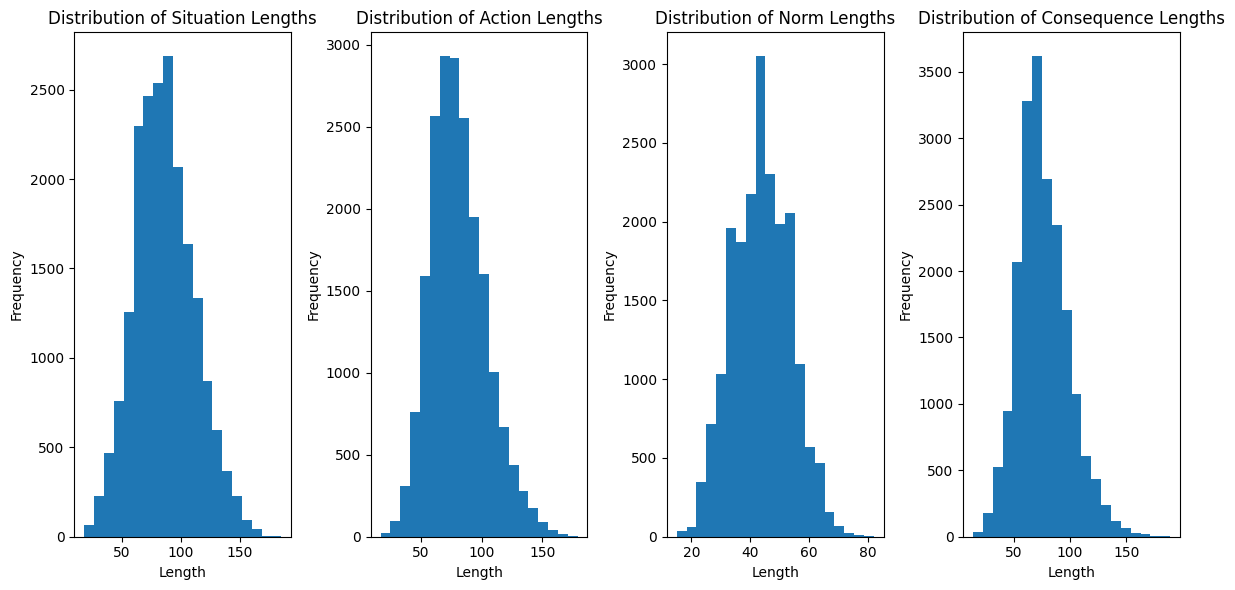

In [ ]:
import matplotlib.pyplot as plt

situation_lengths = [len(text) for text in moral_train_dataset['situation']]
norm_lengths = [len(text) for text in moral_train_dataset['norm']]

moral_action_lengths = []
for action in moral_train_dataset['moral_action']:
  if action != 'not specified':
    moral_action_lengths.append(len(action))
immoral_action_lengths = []
for action in moral_train_dataset['immoral_action']:
  if action != 'not specified':
    immoral_action_lengths.append(len(action))
action_lengths = moral_action_lengths + immoral_action_lengths

moral_consequence_lengths = []
for consequence in moral_train_dataset['moral_consequence']:
  if consequence != 'not specified':
    moral_consequence_lengths.append(len(consequence))
immoral_consequence_lengths = []
for consequence in moral_train_dataset['immoral_consequence']:
  if consequence != 'not specified':
    immoral_consequence_lengths.append(len(consequence))
consequence_lengths = moral_consequence_lengths + immoral_consequence_lengths

plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.hist(situation_lengths, bins=20)
plt.title('Distribution of Situation Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 4, 2)
plt.hist(action_lengths, bins=20)
plt.title('Distribution of Action Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 4, 3)
plt.hist(norm_lengths, bins=20)
plt.title('Distribution of Norm Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 4, 4)
plt.hist(consequence_lengths, bins=20)
plt.title('Distribution of Consequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

print(f"The mean of situation_lengths is: {np.mean(situation_lengths)}")
print(f"The mean of moral_action_lengths (excluding 0) is: {np.mean(moral_action_lengths)}")
print(f"The mean of immoral_action_lengths (excluding 0) is: {np.mean(immoral_action_lengths)}")
print(f"The mean of norm_lengths is: {np.mean(norm_lengths)}")
print(f"The mean of moral_consequence_lengths (excluding 0) is: {np.mean(moral_consequence_lengths)}")
print(f"The mean of immoral_consequence_lengths (excluding 0) is: {np.mean(immoral_consequence_lengths)}")


The mean of situation_lengths is: 85.9598
The mean of moral_action_lengths (excluding 0) is: 80.656
The mean of immoral_action_lengths (excluding 0) is: 80.8544
The mean of norm_lengths is: 43.8687
The mean of moral_consequence_lengths (excluding 0) is: 75.575
The mean of immoral_consequence_lengths (excluding 0) is: 77.0968


In [ ]:
MAX_SEQUENCE_LENGTH = 128

## 0.4. Data Preparation

We will need to tokenize the text into vocab_ids to pass into a BERT model. To do so, we'll need to use the specific tokenizer that goes with the model we're using. In this notebook, we will try several different BERT-style models. Let's
first write a function that will take the text from our dataset and a tokenizer, and encode the text using that tokenizer. Then we'll apply the function to our dataset for each tokenizer and model.

## Original

In [ ]:
def preprocess_moral(data, tokenizer):
    merged_texts = []

    for moral, immoral in zip(data['moral_action'], data['immoral_action']):
        # Ignore "not specified" values for moral and immoral actions
        if moral.lower() == "not specified":
            action_text = immoral
        elif immoral.lower() == "not specified":
            action_text = moral
        else:
            action_text = f"{moral} {immoral}"  # Merge both sentences

        # Add the [CLS] token at the beginning, followed by situation, norm, and action_text, all separated by [SEP]
        #action_text = f"[CLS] {action_text} [SEP]"

        merged_texts.append(action_text)  # Store the merged text

    # Tokenize the batch of merged sentences
    encoded = tokenizer.batch_encode_plus(
        merged_texts,
        max_length=MAX_SEQUENCE_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="pt"
    )

    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "token_type_ids": encoded["token_type_ids"]
    }


## Check tokenizers

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
moral_train_dataset['moral_action'][1]

'not specified'

In [ ]:
bert_tokenizer(moral_train_dataset['moral_action'][1],
               max_length=MAX_SEQUENCE_LENGTH,
               truncation=True,
               padding='max_length',
               return_tensors='pt')

{'input_ids': tensor([[ 101, 1136, 9467,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0,

In [ ]:
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
roberta_model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
roberta_tokenizer(moral_train_dataset['moral_action'][2],
               max_length=MAX_SEQUENCE_LENGTH,
               truncation=True,
               padding='max_length',
               return_tensors='pt')

{'input_ids': tensor([[    0, 19663,  6990,     5, 12443,     7,  1413,  4364,     4,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

## New from the paper

In [ ]:
"""
def preprocess_moral(data, tokenizer):
    input_texts = []

    for norm, moral_action, immoral_action in zip(data['norm'], data['moral_action'], data['immoral_action']):
        actions = []
        if isinstance(moral_action, str) and moral_action.lower() != "not specified":
            actions.append(moral_action)
        if isinstance(immoral_action, str) and immoral_action.lower() != "not specified":
            actions.append(immoral_action)

        action_text = " [SEP] ".join(actions) if actions else "No action provided"
        input_text = f"[CLS] {norm} [SEP] {action_text} [SEP]"

        input_texts.append(input_text)

    encoded = tokenizer.batch_encode_plus(
        input_texts,
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"]
    }
"""

'\ndef preprocess_moral(data, tokenizer):\n    input_texts = []\n\n    for norm, moral_action, immoral_action in zip(data[\'norm\'], data[\'moral_action\'], data[\'immoral_action\']):\n        actions = []\n        if isinstance(moral_action, str) and moral_action.lower() != "not specified":\n            actions.append(moral_action)\n        if isinstance(immoral_action, str) and immoral_action.lower() != "not specified":\n            actions.append(immoral_action)\n\n        action_text = " [SEP] ".join(actions) if actions else "No action provided"\n        input_text = f"[CLS] {norm} [SEP] {action_text} [SEP]"\n\n        input_texts.append(input_text)\n\n    encoded = tokenizer.batch_encode_plus(\n        input_texts,\n        max_length=MAX_SEQUENCE_LENGTH,\n        padding="max_length",\n        truncation=True,\n        return_attention_mask=True,\n        return_tensors="pt"\n    )\n\n    return {\n        "input_ids": encoded["input_ids"],\n        "attention_mask": encoded["att

## Norm and token sent separately

In [ ]:
"""
def preprocess_moral(data, tokenizer):
    norm_texts = []  # Stores norm texts
    action_texts = []  # Stores action texts

    for norm, moral_action, immoral_action in zip(data['norm'], data['moral_action'], data['immoral_action']):
        actions = []
        if isinstance(moral_action, str) and moral_action.lower() != "not specified":
            actions.append(moral_action)
        if isinstance(immoral_action, str) and immoral_action.lower() != "not specified":
            actions.append(immoral_action)

        action_text = " [SEP] ".join(actions) if actions else "No action provided"

        # Store separately
        norm_texts.append(norm)
        action_texts.append(action_text)

    # Tokenize norm and action separately
    encoded = tokenizer(
        norm_texts,
        action_texts,  # Passed as the second sequence
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,  # Needed for distinguishing input sequences
        return_tensors="pt"
    )

    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "token_type_ids": encoded["token_type_ids"]  # Differentiates norm from action
    }
"""

'\ndef preprocess_moral(data, tokenizer):\n    norm_texts = []  # Stores norm texts\n    action_texts = []  # Stores action texts\n\n    for norm, moral_action, immoral_action in zip(data[\'norm\'], data[\'moral_action\'], data[\'immoral_action\']):\n        actions = []\n        if isinstance(moral_action, str) and moral_action.lower() != "not specified":\n            actions.append(moral_action)\n        if isinstance(immoral_action, str) and immoral_action.lower() != "not specified":\n            actions.append(immoral_action)\n\n        action_text = " [SEP] ".join(actions) if actions else "No action provided"\n\n        # Store separately\n        norm_texts.append(norm)\n        action_texts.append(action_text)\n\n    # Tokenize norm and action separately\n    encoded = tokenizer(\n        norm_texts,\n        action_texts,  # Passed as the second sequence\n        max_length=MAX_SEQUENCE_LENGTH,\n        padding="max_length",\n        truncation=True,\n        return_attention_m


## 1. BERT-based Classification Models

Now we turn to classification with BERT. We will perform classifications with various models that are based on pre-trained BERT models.  If you turn off GPU access while coding and debugging the setup steps, make sure you change the Notebook settings so you can access a GPU when you're ready to train the models.


### 1.1. Basics

Let us first explore some basics of BERT. We'll start by loading the first pretrained BERT model and tokenizer that we'll use ('bert-base-cased').

To explore just the pre-trained portion of the model, we'll use the AutoModel class (equivalent to BertModel, but works for any architecture including BERT). This class gives us the pre-trained model layers up until the last hidden layer (but not any output layer).

In [ ]:
# Load accuracy and F1 metrics
metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)  # Convert logits to class predictions

    # Compute accuracy
    acc = metric_acc.compute(predictions=predictions, references=labels)

    # Compute F1-score (weighted to account for class imbalance)
    f1 = metric_f1.compute(predictions=predictions, references=labels, average="weighted")

    # Return both metrics
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}


## Original

In [ ]:
from transformers import Trainer, TrainingArguments

def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   batch_size=16,
                                   num_epochs=2):
    """
    Preprocess the data using the given tokenizer (now merging moral_action and immoral_action).
    Create the training arguments and trainer for the given model and data.
    Then train it.
    """

    # Preprocess train and dev data, handling batched input correctly
    preprocessed_train_data = train_data.map(preprocess_moral, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_moral, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Format dataset to match model input expectations
    def format_dataset(example):
        return {
            "input_ids": example["input_ids"],
            "attention_mask": example["attention_mask"],
            "token_type_ids": example["token_type_ids"],
            "labels": example["label"] if "label" in example else 0  # Default to 0 if missing
        }


    formatted_train_data = preprocessed_train_data.map(format_dataset, remove_columns=preprocessed_train_data.column_names)
    formatted_dev_data = preprocessed_dev_data.map(format_dataset, remove_columns=preprocessed_dev_data.column_names)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="roberta-large-lora-sequence-classification",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.05,
        learning_rate=2e-5,
        logging_dir="./logs",
        logging_steps=200
    )

    # Create Trainer instance
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=formatted_train_data,
        eval_dataset=formatted_dev_data,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()


## Model Training

In [ ]:
r = 8
lora_alpha = 32
lora_dropout = 0.1

In [ ]:
"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,838,082 || all params: 357,199,876 || trainable%: 0.5146


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.448500,0.457459,0.809000,0.808190
2,0.415400,0.446953,0.816000,0.814874
3,0.403300,0.434319,0.817500,0.816996


## Testing lora alpha

In [ ]:
# testing different hyperparameter
r = 8
lora_alpha = 8
lora_dropout = 0.1



In [ ]:
"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,838,082 || all params: 357,199,876 || trainable%: 0.5146


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.476200,0.479469,0.795000,0.794259
2,0.429400,0.447672,0.809500,0.808602
3,0.427400,0.442671,0.811500,0.810585


In [ ]:
# testing different hyperparameter
r = 8
lora_alpha = 16
lora_dropout = 0.1


"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,838,082 || all params: 357,199,876 || trainable%: 0.5146


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.432500,0.502848,0.788500,0.785981
2,0.391300,0.464627,0.806500,0.804972
3,0.408800,0.446355,0.810500,0.809733


In [ ]:
# testing different hyperparameter
r = 8
lora_alpha = 24
lora_dropout = 0.1

"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,838,082 || all params: 357,199,876 || trainable%: 0.5146


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.443400,0.445191,0.806500,0.806496
2,0.390500,0.428215,0.818500,0.818054
3,0.363000,0.435793,0.821500,0.820844


## Testing r

In [ ]:
# testing different hyperparameter
r = 4
lora_alpha = r*3
lora_dropout = 0.1

"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.466500,0.460841,0.802000,0.801186
2,0.433700,0.450324,0.808000,0.807134
3,0.425900,0.443606,0.815500,0.814800


In [ ]:
# testing different hyperparameter
r = 2
lora_alpha = r*3
lora_dropout = 0.1

"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.488500,0.481456,0.787000,0.786204
2,0.447200,0.468998,0.801500,0.800140
3,0.443200,0.453114,0.808500,0.807623


In [ ]:
# testing different hyperparameter
r = 1
lora_alpha = r*3
lora_dropout = 0.1

"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,149,954 || all params: 356,511,748 || trainable%: 0.3226


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.539700,0.519317,0.767500,0.766559
2,0.463600,0.484634,0.788000,0.786529
3,0.459800,0.469424,0.796000,0.795024


## Testing lora layers

In [ ]:
# testing different hyperparameter
r = 8
lora_alpha = r*3
lora_dropout = 0.1

"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
    target_modules=["query"]
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.494300,0.476719,0.788500,0.788316
2,0.453100,0.464423,0.802500,0.802090
3,0.450800,0.465296,0.800500,0.799838


In [ ]:
# testing different hyperparameter
r = 8
lora_alpha = r*3
lora_dropout = 0.1

"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
    target_modules=["key"]
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.541800,0.519784,0.768000,0.767570
2,0.475300,0.493485,0.785500,0.784686
3,0.467600,0.490326,0.788500,0.787444


In [ ]:
# testing different hyperparameter
r = 8
lora_alpha = r*3
lora_dropout = 0.1

"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
    target_modules=["value"]
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.470700,0.460959,0.802000,0.801355
2,0.422300,0.460362,0.813500,0.813023
3,0.413900,0.448488,0.814500,0.813863


In [ ]:
# testing different hyperparameter
r = 8
lora_alpha = r*3
lora_dropout = 0.1

"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-large
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

# LORA set up

for name, param in classification_model.named_parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
    target_modules=["query","key","value"]
)

classification_model = get_peft_model(classification_model, peft_config)
classification_model.print_trainable_parameters()

_= classification_model.to("cuda")

# Model training

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,231,298 || all params: 357,593,092 || trainable%: 0.6240


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.445100,0.466322,0.799500,0.797243
2,0.406000,0.477929,0.811000,0.809129
3,0.377100,0.443676,0.817500,0.816807
